In [ ]:
!pip3 install gym
!pip3 install stable-baselines3[extra]
!pip3 install 'shimmy>=2.0'
!pip3 install pandas
!pip3 install pybullet

# Environment Setup

## Gym Class

In [1]:
import gym
from gym import spaces
import numpy as np
import pybullet as p
import pybullet_data
import cv2
import math
import time
import random
import joblib

class PandaTennisEnv(gym.Env):
    def __init__(self, enable_gui = True):
        super(PandaTennisEnv, self).__init__()
        
        # preset parameters
        self.time_step = 1.0 / 240.0
        self.wait_period = 40 # How long should the system rest to adjust joints
        self.step_number = 0 # step number count starts from 0
        
        # RGB Camera parameters
        self.camera_width = 640
        self.camera_height = 480
        self.fov = 60  # Field of view in degrees
        self.aspect = self.camera_width / self.camera_height
        self.near = 0.01
        self.far = 100
        self.cam_pos = [-1.5, 0, 1.5]  # Camera position
        self.target = [0, 0, 1.5]  # Look-at point
        self.up_vector = [0, 0, 1]  # Up direction
        self.enable_camera = False
        self.enable_opencv_window = False
        
        # Environmental Factors
        self.gravitational_acceleration = 9.802 # m/s^2 (actual value of g in new york city: https://physicslabs.ccnysites.cuny.edu/labs/207/207-little-g/littleg.php#:~:text=In%20fact%20in%20New%20York,of%20the%20North%2DEast%20US. )
        self.lateral_friction = 0.2 ## Table has separate parameters
        self.spinning_friction = 0.05
        self.rolling_friction = 0.05
        self.restitution = 0.9
        self.air_resistance_coefficient = 0.001

        # Terrain properties
        self.ground_texture = 'terrain_visual/green-terrain.png'
        self.terrain_size = 256  # Number of grid points per side
        self.terrain_scale = 0.5  # Horizontal scaling
        self.terrain_height_scale = 0.1  # Maximum height of terrain

        # Panda Parameters
        self.panda_init_pos = [-2.3, 0, 0.75]
        self.panda_preset_position = [0, 0, 0, 0, 0, 2.258, 0.437]

        # Husky Parameters
        self.husky_init_pos = [-1.9, 0, 0]
        self.enable_husky_movement = False # This fixes the husky base with ground disabling husky control
        
        # Wall properties
        self.wall_size = [0.55, 1.5, 1.0]  # [length, thickness, height]
        self.wall_mass = 2000  # Static wall
        self.wall_color = [0.5, 0.5, 0.5, 1]
        self.wall_position = [5, 0.0, 0.0]  # Adjust the position as needed
        self.wall_orientation = p.getQuaternionFromEuler([0, 0, 0])  # No rotation

        # Table dimensions and properties
        self.table_length = 2.74  # meters
        self.table_width = 1.525  # meters
        self.table_height = 0.76  # meters
        self.table_position = [0, 0, self.table_height / 2]  # Move table to (2, 0)
        self.table_restitution = 0.9
        self.table_lateral_friction = 0.2
        self.table_spinning_friction = 0.05
        self.table_rolling_friction = 0.05


        # ball properties
        self.ball_radius = 0.0335  # Radius (6.7 cm diameter / 2)
        self.ball_mass = 0.058  # Standard tennis ball mass in kg
        self.ball_color = [1, 1, 0, 1]
        self.ball_launcher_height = 0.3048 ## 30.48 cm
        self.ball_position = [1.25, 0.0, self.table_height + 0.25 * self.ball_launcher_height]  # ball is thrown from the ball launcher
        self.ball_initial_vel = [0, 0, 3]
        self.ball_initial_angular_vel = [0, 0, 0] # this is the spin
        
     
        # Define observation and action spaces
        husky_low = np.array([-5, -5, -5, -5], dtype=np.float32)  # Husky wheels: -5 to +5
        husky_high = np.array([5, 5, 5, 5], dtype=np.float32)
        panda_low = np.radians([-180]*7)  # Panda joints: -180 degrees
        panda_high = np.radians([180]*7)  # Panda joints: +180 degrees
        low = np.concatenate([panda_low, husky_low])
        high = np.concatenate([panda_high, husky_high])
        self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(44,), dtype=np.float32)

        # Connect to PyBullet in GUI mode
        self.physics_client = p.connect(p.GUI if enable_gui else p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self.initialize_everything()
        
        

    def initialize_everything(self):
        p.setTimeStep(self.time_step)
        p.setGravity(0,0,-self.gravitational_acceleration)
        self.step_number = 0
        
        self.plane_id = p.loadURDF("plane.urdf")
        
        # Apply a texture to the uneven plane
        texture_id = p.loadTexture(self.ground_texture)  # Use a texture from PyBullet's data
        p.changeVisualShape(self.plane_id, -1, textureUniqueId=texture_id)
        if self.enable_husky_movement:
            self.husky_id = p.loadURDF("husky/husky.urdf", self.husky_init_pos) # allows husky to move
        else:
            self.husky_id = p.loadURDF("husky/husky.urdf", self.husky_init_pos, useFixedBase = True) # disables husky movement
            
        self.panda_id = p.loadURDF("modURDFs/panda_pybullet/franka_panda_mod/panda.urdf", self.panda_init_pos)

        ## Build Wall
        # self.build_wall()
        
        self.mount_bodies()
        
        p.changeDynamics(bodyUniqueId=self.plane_id, linkIndex=-1,
                         restitution=self.restitution, 
                         lateralFriction=self.lateral_friction, 
                         spinningFriction = self.spinning_friction, 
                         rollingFriction = self.rolling_friction,
                        )
        
        # Apply dynamics properties to all links of panda
        num_joints = p.getNumJoints(self.panda_id)
        for link_index in range(-1, num_joints):  # -1 refers to the base link
            p.changeDynamics(self.panda_id, link_index, 
                             restitution=self.restitution, 
                             lateralFriction=self.lateral_friction,
                             spinningFriction = self.spinning_friction, 
                             rollingFriction = self.rolling_friction,
                            )

        # Apply damping for all joints
        for joint_index in range(num_joints):
            p.changeDynamics(self.panda_id, joint_index, 
                             linearDamping=0.04, 
                             angularDamping=0.04)

        
        p.addUserDebugPoints([self.ball_position], [[0.1, 0.1, 0]], 10)  # position of the launcher
        
        self.get_new_ball(self.ball_position)
        self.throw_ball(self.ball_initial_vel, self.ball_initial_angular_vel)

        ## build table
        self.build_table()

    def build_wall(self):
        # Create wall collision shape
        wall_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=self.wall_size)
        # Create wall visual shape
        wall_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=self.wall_size, rgbaColor=self.wall_color)  # Grey color
        # Create the wall body
        self.wall_id = p.createMultiBody(
            baseMass=self.wall_mass,
            baseCollisionShapeIndex=wall_collision,
            baseVisualShapeIndex=wall_visual,
            basePosition=self.wall_position,
            baseOrientation=self.wall_orientation
        )
        p.changeDynamics(self.wall_id, -1, lateralFriction=self.lateral_friction, restitution=self.restitution)



    def build_table(self):
        # Create the table as a box
        table_visual = p.createVisualShape(
            shapeType=p.GEOM_BOX,
            halfExtents=[self.table_length / 2, self.table_width / 2, self.table_height / 2],
            rgbaColor=[0, 0.6, 0, 1],  # Dark green color for the table
        )
        
        table_collision = p.createCollisionShape(
            shapeType=p.GEOM_BOX,
            halfExtents=[self.table_length / 2, self.table_width / 2, self.table_height / 2],
        )
        
        self.table_id = p.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=table_collision,
            baseVisualShapeIndex=table_visual,
            basePosition=self.table_position,
        )
        
        # Set the physical properties of the table
        p.changeDynamics(self.table_id, -1, 
                         restitution=self.table_restitution, 
                         lateralFriction=self.table_lateral_friction, 
                         spinningFriction = self.table_spinning_friction, 
                         rollingFriction = self.table_rolling_friction,
                        )
        
        # Draw the court lines
        line_color = [1, 1, 1, 1]  # White color for the lines
        
        # Outer border (2 cm width)
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        
        # Centerline (3 mm width)
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0], self.table_position[1] - self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0], self.table_position[1] + self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1], self.table_height],
            lineToXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1], self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )

    def apply_air_resistance(self):
        velocity, angular_velocity = p.getBaseVelocity(self.ball_id)
        # Calculate air resistance (linear and angular)
        air_resistance_force = [-self.air_resistance_coefficient * v for v in velocity]
        air_resistance_torque = [-self.air_resistance_coefficient * av for av in angular_velocity]
        
        # Apply forces and torques
        p.applyExternalForce(self.ball_id, -1, air_resistance_force, [0, 0, 0], p.WORLD_FRAME)
        p.applyExternalTorque(self.ball_id, -1, air_resistance_torque, p.WORLD_FRAME)
        
    
    def mount_bodies(self):
        # mount the panda on the husky
        husky_chassis_link_index = 0  # chasis link index
        
        # Create the fixed constraint
        self.husky_panda_mount = p.createConstraint(
            parentBodyUniqueId=self.husky_id,
            parentLinkIndex=husky_chassis_link_index,
            childBodyUniqueId=self.panda_id,
            childLinkIndex=-1,  # -1 means the base link of the child
            jointType=p.JOINT_FIXED,
            jointAxis=[0, 0, 0],
            parentFramePosition=[0.3, 0, 0.25],  # Offset on Husky where the Panda arm will be attached
            childFramePosition=[0, 0, 0]  # Offset on Panda where it attaches to Husky
        )

        for i in range (self.wait_period):
            p.stepSimulation()

        # set panda to preset position
        for joint_index, target_position in zip(range(0, 7), self.panda_preset_position):
            p.setJointMotorControl2(
                bodyUniqueId=self.panda_id,
                jointIndex=joint_index,
                controlMode=p.POSITION_CONTROL,
                targetPosition=target_position,
                force=500  # Adjust max torque/force as needed
            )

        for i in range (self.wait_period):
            p.stepSimulation()



    def get_camera_feed(self):
        # Compute view and projection matrices
        view_matrix = p.computeViewMatrix(self.cam_pos, self.target, self.up_vector)
        proj_matrix = p.computeProjectionMatrixFOV(self.fov, self.aspect, self.near, self.far)
        
        # Capture the image
        _, _, rgb_img, _, _ = p.getCameraImage(self.camera_width, 
                                               self.camera_height, 
                                               view_matrix, 
                                               proj_matrix, 
                                               # renderer=p.ER_BULLET_HARDWARE_OPENGL,
                                              )
        rgb_img = np.array(rgb_img, dtype=np.uint8).reshape((self.camera_height, self.camera_width, 4))
        if self.enable_opencv_window:
            cv2.imshow("RGB Camera", rgb_img[:, :, :3])  # Ignore alpha channel
            if cv2.waitKey(1) != -1:  # If any key is pressed, exit 
                cv2.destroyAllWindows()
                self.enable_opencv_window = False
        return rgb_img


    
    def reset(self):
        # Reset simulation
        p.resetSimulation()
        p.removeAllUserDebugItems()
        self.initialize_everything()
        return self._get_observation()
    
    def _get_observation(self):

        # ball states
        ball_pos, ball_orn = p.getBasePositionAndOrientation(self.ball_id)
        ball_linear_velocity, ball_angular_velocity = p.getBaseVelocity(self.ball_id) # Ignore angular velocity. Difficult to estimate in reality
        

        # bat states
        
        bat_states = p.getLinkState(self.panda_id, p.getNumJoints(self.panda_id) - 1)
        bat_com_pos = bat_states[0]  # Position is a tuple (x, y, z)
        bat_com_orn = bat_states[1]


        # Husky states
        husky_pos, husky_orn = p.getBasePositionAndOrientation(self.husky_id)
        husky_lin_vel, husky_ang_vel = p.getBaseVelocity(self.husky_id)
        
        

        # Panda states
        panda_num_joints = p.getNumJoints(self.panda_id)
        panda_joint_states = p.getJointStates(self.panda_id, range(panda_num_joints))
        panda_joint_pos = [state[0] for state in panda_joint_states]
        panda_joint_vel = [state[1] for state in panda_joint_states]
        
        system_state = np.concatenate([
                np.array(ball_pos),                 # 3 values: Ball position
                np.array(ball_orn),                # 4 values: Ball orientation
                np.array(ball_linear_velocity),    # 3 values: Ball linear velocity
                np.array(bat_com_pos),                 # 3 values: Bat position
                np.array(bat_com_orn),                 # 4 values: Bat orientation
                np.array(husky_pos),               # 3 values: Husky position
                np.array(husky_orn),               # 4 values: Husky orientation
                np.array(husky_lin_vel),           # 3 values: Husky linear velocity
                np.array(husky_ang_vel),           # 3 values: Husky angular velocity
                np.array(panda_joint_pos),         # 7 values: Panda joint positions
                np.array(panda_joint_vel)          # 7 values: Panda joint velocities
            ])
        return system_state


    def get_new_ball(self, initial_position):
        # Create ball collision shape
        ball_collision = p.createCollisionShape(p.GEOM_SPHERE, radius=self.ball_radius)
        # Create ball visual shape
        ball_visual = p.createVisualShape(p.GEOM_SPHERE, radius=self.ball_radius, rgbaColor=self.ball_color)  # Yellow color
        # Create the ball body
        self.ball_id = p.createMultiBody(
            baseMass=self.ball_mass,
            baseCollisionShapeIndex=ball_collision,
            baseVisualShapeIndex=ball_visual,
            basePosition=initial_position,
        )
        p.changeDynamics(self.ball_id, -1, lateralFriction=self.lateral_friction, restitution=self.restitution)

    def set_ball_init_position(self, initial_position):
        p.resetBasePositionAndOrientation(self.ball_id, initial_position, [0, 0, 0, 1])
    
    # Function to draw the COM of bat and axes
    def visualize_com(self):
        # Function to rotate a vector by a quaternion
        def rotate_vector(vector, quaternion):
            return p.multiplyTransforms([0, 0, 0], quaternion, vector, [0, 0, 0, 1])[0]
        
        # Get COM for the base link
        bat_states = p.getLinkState(self.panda_id, p.getNumJoints(self.panda_id) - 1)
        base_pos = bat_states[0]  # Position is a tuple (x, y, z)
        base_orn = bat_states[1]
        
        # Transform the local COM to global coordinates
        com_global = base_pos
        
        # Define local unit axes
        axis_length = 0.2  # Length of the axes
        x_axis = [axis_length, 0, 0]
        y_axis = [0, axis_length, 0]
        z_axis = [0, 0, axis_length]
        
        # Rotate local axes to match the base's orientation
        x_axis_global = rotate_vector(x_axis, base_orn)
        y_axis_global = rotate_vector(y_axis, base_orn)
        z_axis_global = rotate_vector(z_axis, base_orn)
        
        # Compute global endpoints of the axes
        x_end = [com_global[i] + x_axis_global[i] for i in range(3)]
        y_end = [com_global[i] + y_axis_global[i] for i in range(3)]
        z_end = [com_global[i] + z_axis_global[i] for i in range(3)]
        
        # Draw lines for the axes
        p.addUserDebugLine(com_global, x_end, [1, 0, 0], 3)  # Red for X-axis
        p.addUserDebugLine(com_global, y_end, [0, 1, 0], 3)  # Green for Y-axis
        p.addUserDebugLine(com_global, z_end, [0, 0, 1], 3)  # Blue for Z-axis
        

    # remove all the lines or user debug texts added
    def removeUserDebugItems(self):
        p.removeAllUserDebugItems()

    
    def throw_ball(self, initial_velocity, angular_velocity = [0, 0, 0]):
        # Throw the ball with initial velocity
        # initial_velocity = [3, 0, 2]  # Velocity in x, y, z directions
        p.resetBaseVelocity(self.ball_id, linearVelocity=initial_velocity, angularVelocity = angular_velocity)



    def panda_IK(self, desired_bat_com_position, desired_bat_com_orientation):
        end_effector_index = 6
        joint_angles = p.calculateInverseKinematics(end.panda_id, end_effector_index, desired_end_effector_position, desired_end_effector_orientation)
        return joint_angles

    def step(self, action):
        self.apply_air_resistance()
        self.step_number += 1
        panda_actions = action[:7]  # First 7 values for Panda arm
        husky_actions = action[7:]  # Last 4 values for Husky wheels


         # Apply actions to Husky wheels
        panda_joints = [0, 1, 2, 3, 4, 5, 6]  # Joint indices for the Husky wheels
        for i, act in enumerate(panda_actions):
            p.setJointMotorControl2(
                self.panda_id,
                panda_joints[i],
                p.VELOCITY_CONTROL,
                targetVelocity=act  # Use velocity directly within [-5, 5]
            )


        
        
        # Apply actions to Husky wheels
        wheel_joints = [2, 3, 4, 5]  # Joint indices for the Husky wheels
        for i, act in enumerate(husky_actions):
            p.setJointMotorControl2(
                self.husky_id,
                wheel_joints[i],
                p.VELOCITY_CONTROL,
                targetVelocity=act  # Use velocity directly within [-5, 5]
            )
    
        # Step the simulation
        p.stepSimulation()
        if self.enable_camera:
            self.get_camera_feed()
    
        # Calculate reward and check if done
        reward = self._calculate_reward()
        done = self._check_done()

        ## Enable markers
        # self.visualize_com()
        # self.removeUserDebugItems()
        return self._get_observation(), reward, done, {}

    
    def _calculate_reward(self):
        total_reward = -1
        return total_reward
    
    def _check_done(self):
        # Get the position of the ball
        ball_pos, ball_orn = p.getBasePositionAndOrientation(self.ball_id)
        
        # Get the vertical velocity of the ball (in the z direction)
        ball_linear_velocity, ball_angular_velocity = p.getBaseVelocity(self.ball_id)
        ball_vertical_velocity = ball_linear_velocity[2]  # The z component of velocity
        
        # Done condition: Ball hits the ground (z position below a threshold or vertical velocity down)
        if ball_pos[2] < 0.1:
            # Ball has hit the ground, episode should end
            return True
        
        return False
    
    def render(self, mode="human"):
        pass  # PyBullet GUI provides rendering
    
    def close(self):
        p.disconnect()


pybullet build time: Nov 28 2023 23:51:11


## Start the sim

In [2]:
# Test the model
env = PandaTennisEnv(enable_gui = True)

/home/sakib/.local/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## Test Run

In [3]:
obs = env.reset()
env.set_ball_init_position([1, 0, 2])
env.throw_ball([1, 0, 2], [3, 0, 0])
for i in range(100000):
    # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
    panda_action = [0]*7 # panda_velocities
    husky_action = [0]*4 # wheel velocity
    action = panda_action + husky_action
    obs, reward, done, info = env.step(action)
    # print(obs)
    time.sleep(1/240)


KeyboardInterrupt: 

## Enable Sliders for Panda Joint Control

In [ ]:
# Get joint information
num_joints = p.getNumJoints(env.panda_id)
joint_indices = [i for i in range(num_joints) if p.getJointInfo(env.panda_id, i)[2] == p.JOINT_REVOLUTE]

# Create sliders for each joint
sliders = {}
for joint_index in joint_indices:
    joint_info = p.getJointInfo(env.panda_id, joint_index)
    joint_name = joint_info[1].decode("utf-8")
    joint_limit_low = joint_info[8]
    joint_limit_high = joint_info[9]
    slider = p.addUserDebugParameter(joint_name, joint_limit_low, joint_limit_high, 0.0)
    sliders[joint_index] = slider

# Simulation loop
while True:
    # Read slider values and control joints
    for joint_index, slider in sliders.items():
        slider_value = p.readUserDebugParameter(slider)
        p.setJointMotorControl2(
            bodyUniqueId=env.panda_id,
            jointIndex=joint_index,
            controlMode=p.POSITION_CONTROL,
            targetPosition=slider_value,
            force=500  # Set maximum torque/force
        )
    
    # Step the simulation
    panda_action = [0]*7 # panda_velocities
    husky_action = [0]*4 # wheel velocity
    action = panda_action + husky_action
    # obs, reward, done, info = env.step(action)
    p.stepSimulation()
    time.sleep(0.01)  # Add a small delay for stability

## Make Panda Dance (don't use - panda uses velocity control now)

In [3]:
# Get number of joints
num_joints = p.getNumJoints(env.panda_id)

# Define the range of motion for the joints
joint_ranges = {
    0: (-2.9, 2.9),
    1: (-1.76, 1.76),
    2: (-2.9, 2.9),
    3: (-3.07, -0.07),
    4: (-2.9, 2.9),
    5: (-0.017, 3.75),
    6: (-2.9, 2.9),
}

# Simulation parameters
duration = 100  # Total time for the dance (seconds)
frequency = 0.05  # Frequency of oscillation (Hz)

# Create a time-based loop
start_time = time.time()
while time.time() - start_time < duration:
    current_time = time.time() - start_time

    # Set joint positions in a sinusoidal pattern
    for joint_index in range(7):  # Panda has 7 controllable joints
        joint_range = joint_ranges[joint_index]
        joint_center = (joint_range[0] + joint_range[1]) / 2
        joint_amplitude = (joint_range[1] - joint_range[0]) / 4

        # Calculate target position using a sine wave
        target_position = joint_center + joint_amplitude * np.sin(2 * np.pi * frequency * current_time + joint_index)

        # Set joint position
        p.setJointMotorControl2(
            bodyUniqueId=env.panda_id,
            jointIndex=joint_index,
            controlMode=p.POSITION_CONTROL,
            targetPosition=target_position,
        )
    # Clear previous lines
    env.removeUserDebugItems()
    
    # Visualize the COM of the bat
    env.visualize_com()
    print(env._get_observation())

    # Step simulation
    p.stepSimulation()
    time.sleep(1 / 240)  # Match the simulation timestep (240 Hz)

[ 3.50000000e+00  0.00000000e+00  1.50000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  3.00000000e+00  3.15484136e-01  1.61483612e-02
  6.81534565e-01  2.15230606e-01 -3.93574770e-01 -1.38311722e-01
  8.82974832e-01 -1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.52906540e-08  1.07963089e+00
  1.66750824e-03 -3.41682652e-01 -7.60639285e-04  2.25312327e+00
  4.30690598e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.20775077e-06 -4.55350728e+00  5.45318269e-02  9.11418475e+00
 -8.89656871e-03  1.31133755e-01  1.71564687e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[ 3.50000000e+00  0.00000000e+00  1.51232149e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  2.95715833e+00  3.22390661e-01  1.6057

KeyboardInterrupt: 

In [ ]:
pybullet_data.getDataPath()

In [ ]:
# Test the model
env = PandaTennisEnv(enable_gui = True)

In [ ]:
while True:
    # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
    panda_action = [0.0]*7 # panda_velocities
    husky_action = [-1]*4 # wheel velocity
    action = panda_action + husky_action
    obs, reward, done, info = env.step(action)
    # print(obs)
    time.sleep(1/240)
    # husky_position, husky_orientation = p.getBasePositionAndOrientation(env.husky_id)
    # print(husky_position, husky_orientation)
    # Extract velocities
    joint_states = p.getJointStates(
        bodyUniqueId=env.panda_id,
        jointIndices=range(7)
    )

    velocities = [joint_state[1] for joint_state in joint_states]
    print(f"Joint Velocities: {velocities}")
    p.stepSimulation()

# Residual Estimation

## Estimate Initial Velocity

In [3]:
def estimate_initial_velocity(pos1, pos2, delta_t):
    """
    Estimate the initial velocity of a ball given two consecutive positions.

    Args:
    - pos1 (list or np.array): First position [x1, y1, z1].
    - pos2 (list or np.array): Second position [x2, y2, z2].
    - delta_t (float): Time interval between the two positions.

    Returns:
    - velocity (np.array): Estimated velocity [vx, vy, vz].
    """
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)

    # Compute velocity
    velocity = (pos2 - pos1) / delta_t

    return velocity

## Finding Bounce and hitting Point

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def get_bounce_position_and_hit_position(initial_position, # for the ball 
                                         initial_velocity, # for the ball
                                         table_height, 
                                         coeff_restitution, 
                                         x_a, # x = a plane position (provide the value of a)
                                         g,
                                        ):
    # Compute bounce time
    t_bounce = (initial_velocity[2] + np.sqrt(initial_velocity[2]**2 + 2 * g * (initial_position[2] - table_height))) / g
    bounce_position = initial_position + initial_velocity * t_bounce - 0.5 * np.array([0, 0, g]) * t_bounce**2
    bounce_velocity = np.array([initial_velocity[0], initial_velocity[1], -coeff_restitution * (initial_velocity[2] - g * t_bounce)])
    
    # Compute time to reach x = a after bounce
    t_hit = (x_a - bounce_position[0]) / bounce_velocity[0]
    hit_position = bounce_position + bounce_velocity * t_hit - 0.5 * np.array([0, 0, g]) * t_hit**2
    # --- 6️⃣ Compute Velocity at Hit Position ---
    hit_velocity = np.array([
        bounce_velocity[0],   # vx remains constant
        bounce_velocity[1],   # vy remains constant
        bounce_velocity[2] - g * t_hit  # v_z changes due to gravity
    ])
    return bounce_position, bounce_velocity, hit_position, hit_velocity, t_bounce, t_hit 



## Draw the x = a plane

In [5]:
def draw_xa_plane(x_a):
    # Define grid size
    y_min, y_max = -1.5, 1.5
    z_min, z_max = 0, 2
    num_lines = 1  # Increase for finer grid
    
    for i in range(num_lines + 1):
        y = y_min + i * (y_max - y_min) / num_lines
        z = z_min + i * (z_max - z_min) / num_lines
        
        # Vertical grid lines
        p.addUserDebugLine([x_a, y_min, z], [x_a, y_max, z], [0, 1, 0])
        # Horizontal grid lines
        p.addUserDebugLine([x_a, y, z_min], [x_a, y, z_max], [0, 1, 0])
        # 

## Set ball initial position and velocity randomly

In [6]:
def set_random_ball_conditions(ball_id):
    """Sets a random initial position and velocity ensuring the ball bounces on the table once and reaches x = a"""
    TABLE_HEIGHT = env.table_height  # Typical table tennis table height in meters
    GRAVITY = 9.81  # Gravity in m/s^2
    RESTITUTION = 0.9  # Coefficient of restitution (bounciness)
    X_TARGET = -0.2  # The x = a plane where the ball should reach after one bounce
    Vx_ADJUST = 2.0 # add a slightly more Vx 

    # # Choose a random initial position (starting on one side of the table)
    # x0 = np.random.uniform(3.9, 4.1)  # Start from left side of the table
    # y0 = np.random.uniform(-0.1, 0.1)  # Random lateral position
    # z0 = np.random.uniform(TABLE_HEIGHT + 0.3, TABLE_HEIGHT + 1.0)  # Above the table
    [x0, y0, z0] = env.ball_position # ball launcher position

    # Choose a valid initial vertical velocity to ensure it lands on the table
    vz0 = np.random.uniform(3.0, 4.5)  # Positive upwards velocity

    # Compute time to bounce
    tb = (vz0 + np.sqrt(vz0**2 + 2 * GRAVITY * (z0 - TABLE_HEIGHT))) / GRAVITY

    # Compute velocity after bounce
    vz_after_bounce = -RESTITUTION * vz0

    # Compute required x velocity to reach x = a
    tf = abs(vz_after_bounce) / GRAVITY * 2  # Approximate time after bounce
    vx0 = ((X_TARGET - x0) / (tb + tf)) - Vx_ADJUST  # Solve for vx0

    # Random y velocity (ensure it stays on table)
    vy0 = np.random.uniform(-0.7, 0.7)

    # Set ball position and velocity in PyBullet
    env.set_ball_init_position([x0, y0, z0])
    env.throw_ball([vx0, vy0, vz0])

    # print(f"Set initial position: {x0:.3f}, {y0:.3f}, {z0:.3f}")
    # print(f"Set initial velocity: {vx0:.3f}, {vy0:.3f}, {vz0:.3f}")

## Write the results in a CSV file

In [7]:
import csv

# Define the CSV file name
csv_filename = "ball_trajectory_data_finegrained.csv"

# Define the header for the CSV file
csv_header = ["initial_x", "initial_y", "initial_z", 
              "initial_vx", "initial_vy", "initial_vz",
              "distance_to_x_a", "estimated_hit_x", "estimated_hit_y", "estimated_hit_z",
              "real_hit_x", "real_hit_y", "real_hit_z",
              "delta_x", "delta_y", "delta_z",]

# Function to write data to CSV
def write_to_csv(initial_pos, initial_vel, distance_to_x_a, estimated_hit, real_hit, delta):
    """Writes trajectory data to a CSV file."""
    data = [
        initial_pos[0], initial_pos[1], initial_pos[2], 
        initial_vel[0], initial_vel[1], initial_vel[2], 
        distance_to_x_a, estimated_hit[0], estimated_hit[1], estimated_hit[2],
        real_hit[0], real_hit[1], real_hit[2], 
        delta[0], delta[1], delta[2]
    ]

    # Check if the file exists and write the header only once
    try:
        with open(csv_filename, mode='x', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(csv_header)  # Write header
            writer.writerow(data)
    except FileExistsError:
        with open(csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data)


## Test Run 

Predicted Bounce Position: [-1.4364313  -0.45229289  0.76      ]
Predicted Hit Position on x = -2.2 : [-2.2        -0.58084882  1.54172223]


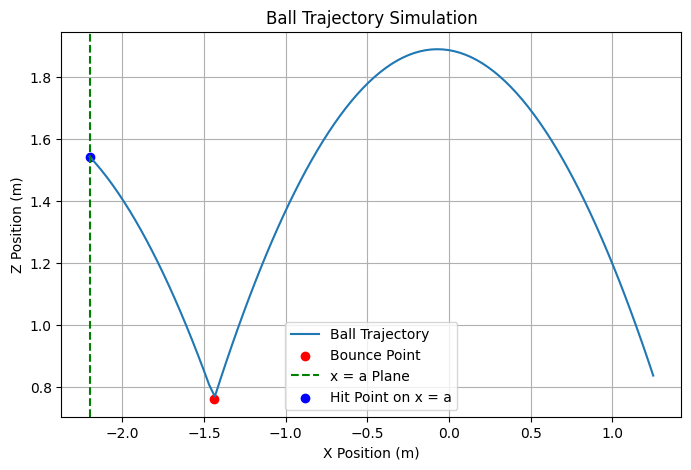

In [8]:

# Constants
g = env.gravitational_acceleration  # Gravity (m/s^2)
table_height = env.table_height  # Table tennis table height in meters
x_a = -2.2  # The 'x = a' plane where we check the hit
coeff_restitution = env.table_restitution  # Bounce efficiency (0.9 means 90% energy retained)
initial_position = env.ball_position  # Start position (x, y, z)
initial_velocity = np.array([-2.851, -0.480, 4.541])  # Initial velocity (vx, vy, vz)


bounce_position, bounce_velocity, hit_position, hit_velocity, t_bounce, t_hit = get_bounce_position_and_hit_position(initial_position,
                                                                    initial_velocity,
                                                                    table_height,
                                                                    coeff_restitution,
                                                                    x_a,
                                                                    g = 9.81)

print("Predicted Bounce Position:", bounce_position)
print("Predicted Hit Position on x =", x_a, ":", hit_position)

# Plotting the trajectory
t_values = np.linspace(0, t_bounce + t_hit, num=100)
x_traj = np.concatenate([initial_position[0] + initial_velocity[0] * t_values[t_values < t_bounce],
                         bounce_position[0] + bounce_velocity[0] * (t_values[t_values >= t_bounce] - t_bounce)])
y_traj = np.concatenate([initial_position[1] + initial_velocity[1] * t_values[t_values < t_bounce],
                         bounce_position[1] + bounce_velocity[1] * (t_values[t_values >= t_bounce] - t_bounce)])
z_traj = np.concatenate([initial_position[2] + initial_velocity[2] * t_values[t_values < t_bounce] - 0.5 * g * t_values[t_values < t_bounce]**2,
                         bounce_position[2] + bounce_velocity[2] * (t_values[t_values >= t_bounce] - t_bounce) - 0.5 * g * (t_values[t_values >= t_bounce] - t_bounce)**2])

plt.figure(figsize=(8, 5))
plt.plot(x_traj, z_traj, label="Ball Trajectory")
plt.scatter([bounce_position[0]], [bounce_position[2]], color='red', label="Bounce Point")
plt.axvline(x=x_a, color='green', linestyle='--', label="x = a Plane")
plt.scatter([hit_position[0]], [hit_position[2]], color='blue', label="Hit Point on x = a")
plt.xlabel("X Position (m)")
plt.ylabel("Z Position (m)")
plt.legend()
plt.title("Ball Trajectory Simulation")
plt.grid()
plt.show()


In [11]:
obs = env.reset()
env.set_ball_init_position(initial_position)
env.throw_ball(initial_velocity)
draw_xa_plane(x_a)
prev_position = p.getBasePositionAndOrientation(env.ball_id)[0]  # Initial position
for i in range(100000):
    # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
    panda_action = [0]*7 # panda_velocities
    husky_action = [0]*4 # wheel velocity
    action = panda_action + husky_action
    obs, reward, done, info = env.step(action)
    ball_real_position, _ = p.getBasePositionAndOrientation(env.ball_id)
    x, y, z = ball_real_position
    # Check if the ball crossed x = a
    if x < x_a <= prev_position[0]:  # Moving in positive x direction
        # Linear interpolation to find exact crossing point
        alpha = (x_a - prev_position[0]) / (x - prev_position[0])
        hit_y = prev_position[1] + alpha * (y - prev_position[1])
        hit_z = prev_position[2] + alpha * (z - prev_position[2])
        # Mark the hitting point
        p.addUserDebugPoints([[x_a, hit_y, hit_z]], [[0, 0, 1]], 10)  # Red dot
        print(f"Ball hit x = {x_a} at y = {hit_y:.3f}, z = {hit_z:.3f}")
        break
    prev_position = ball_real_position
    time.sleep(1/240)


Ball hit x = -2.2 at y = -0.581, z = 1.113


## The big Loop: data collection for residual predictor

In [8]:
g = 9.8  # Gravity (m/s^2) [We will use this instead of the actual one set in the simulator to ensure our set parameters are different than the actual ones]
table_height = env.table_height  # Table tennis table height in meters
x_a = -1 * env.table_length/2  # The 'x = a' plane where we check the hit
coeff_restitution = 0.85 # different from the simulator. to set inaccuracy in preset parameters. 
num_experiments = 10000
draw_xa_plane(x_a)

for exp in range(num_experiments):
    # env.reset()
    # Set random initial conditions
    set_random_ball_conditions(env.ball_id)
    pos1 = p.getBasePositionAndOrientation(env.ball_id)[0]  # First position
    p.stepSimulation()
    time.sleep(env.time_step)  # Simulate a step
    pos2 = p.getBasePositionAndOrientation(env.ball_id)[0]  # Second position
    d = pos1[0] - x_a
    estimated_initial_velocity = estimate_initial_velocity(pos1, pos2, env.time_step)
    bounce_position, bounce_velocity, estimated_hit_position, estimated_hit_vel, t_bounce, t_hit = get_bounce_position_and_hit_position(pos1,
                                                                        estimated_initial_velocity,
                                                                        table_height,
                                                                        coeff_restitution,
                                                                        x_a,
                                                                        g,                                   
                                                                        )
    
    # p.addUserDebugPoints([estimated_hit_position], [[1, 0, 0]], 10)  # estimated hit point
    prev_position = p.getBasePositionAndOrientation(env.ball_id)[0]  # Initial position
    for i in range(1000):
        # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
        panda_action = [0]*7 # panda_velocities
        husky_action = [0]*4 # wheel velocity
        action = panda_action + husky_action
        obs, reward, done, info = env.step(action)
        
        ball_real_position, _ = p.getBasePositionAndOrientation(env.ball_id)
        x, y, z = ball_real_position
        # Check if the ball crossed x = a
        if x < x_a <= prev_position[0]:  # Moving in positive x direction
            # Linear interpolation to find exact crossing point
            alpha = (x_a - prev_position[0]) / (x - prev_position[0])
            hit_y = prev_position[1] + alpha * (y - prev_position[1])
            hit_z = prev_position[2] + alpha * (z - prev_position[2])
            # Mark the hitting point
            # p.addUserDebugPoints([[x_a, hit_y, hit_z]], [[0, 0, 1]], 10)  # real hit point
            # print(f"Ball hit x = {x_a} at y = {hit_y:.3f}, z = {hit_z:.3f}")
            real_hit_position = [x_a, hit_y, hit_z]
            # p.addUserDebugPoints([real_hit_position], [[1, 0, 0]], 10)  # estimated hit point

            delta = real_hit_position - estimated_hit_position
            write_to_csv(pos1, 
                        estimated_initial_velocity,
                        d,
                        estimated_hit_position,
                        real_hit_position,
                        delta,
                        )
            break
        prev_position = ball_real_position
        # time.sleep(env.time_step)



2025-02-12 14:29:33.955 Python[87125:3058720] _TIPropertyValueIsValid called with 16 on nil context!
2025-02-12 14:29:33.955 Python[87125:3058720] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-02-12 14:29:33.955 Python[87125:3058720] Text input context does not respond to _valueForTIProperty:
2025-02-12 14:30:39.617 Python[87125:3058720] _TIPropertyValueIsValid called with 16 on nil context!
2025-02-12 14:30:39.617 Python[87125:3058720] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-02-12 14:30:39.617 Python[87125:3058720] Text input context does not respond to _valueForTIProperty:
2025-02-12 14:32:37.929 Python[87125:3058720] _TIPropertyValueIsValid called with 16 on nil context!
2025-02-12 14:32:37.929 Python[87125:3058720] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-02-12 14:32:37.929 Python[87125:3058720] Text input context does not respond to _

KeyboardInterrupt: 

## Training the Residual Estimator

Follow this link for residual estimator training:
https://colab.research.google.com/drive/1e3OfrHbjdDuJz5hqRT5LKNmsFiApF1CZ?usp=sharing

# Receiving the ball

## Moveit Plugin

In [37]:
from utils.BotPluginMoveIt import BotPluginMoveIt
mp = BotPluginMoveIt(env, move_group = 'arm', planner_id = 'RRT')

In [33]:
mp.plan_motion(0.58737645, -0.52673307,  0.88380567, 
         
               -7.5*np.pi/8, 
               0, 
               -np.pi/8,
              ignore_pose_control = False)
mp.execute_plan()
# mp.group.go()

[ WARN] [1739640568.638679687]: Fail: ABORTED: TIMED_OUT


In [35]:
from sensor_msgs.msg import JointState
def change_starting_state_moveit():
    # Get the number of joints
    num_joints = p.getNumJoints(env.panda_id)
    
    # Get the current joint states from PyBullet
    joint_positions = []
    joint_names = []
    for joint_index in range(num_joints-3 ):
        joint_info = p.getJointInfo(env.panda_id, joint_index)
        joint_state = p.getJointState(env.panda_id, joint_index)
        joint_names.append(joint_info[1].decode('utf-8'))
        joint_positions.append(joint_state[0])


    current_state = mp.robot.get_current_state()
    # print(joint_positions)

    # Create a JointState message with the joint positions from PyBullet
    joint_state = JointState()
    joint_state.name = joint_names
    joint_state.position = joint_positions
    
    # Update the current state with the new joint state
    current_state.joint_state = joint_state

    # Set the start state to the move_group
    mp.set_starting_state(current_state)

change_starting_state_moveit()

In [38]:
mp.plan_motion(0.21740032, 0,  0.50280637, 
               np.pi/4, 
               0, 
               -np.pi/2)
mp.execute_plan()
# mp.group.go()

## delta estimator call

In [13]:
from delta_estimator_mlp.DeltaEstimatorMLP import DeltaEstimatorMLP
import torch
from utils.BotPluginMoveIt import BotPluginMoveIt
mp = BotPluginMoveIt(env, move_group = 'arm')
# Load the scaler
scaler = joblib.load('delta_estimator_mlp/scaler.pkl')
# Parameters
input_size = 9  # Number of input features
hidden_size = 32  # Number of neurons in the hidden layer
output_size = 2  # Number of output features (delta_y, delta_z)

# Create model and load trained weights
model = DeltaEstimatorMLP(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('delta_estimator_mlp/delta_estimator_mlp.pth'))
model.eval()

# Sample inference code
def calculate_delta_v2(input_features):
    # Convert input features to tensor
    input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    
    # Perform inference
    with torch.no_grad():
        prediction = model(input_tensor)

    # print(prediction)
    # Inverse transform the prediction to get original values
    prediction_original = scaler.inverse_transform(prediction.numpy())
    
    return prediction_original[0]


## Panda Receives the ball

In [14]:

g = 9.8  # Gravity (m/s^2) [We will use this instead of the actual one set in the simulator to ensure our set parameters are different than the actual ones]
table_height = env.table_height  # Table tennis table height in meters
x_a = -1 * env.table_length/2  # The 'x = a' plane where we check the hit
coeff_restitution = 0.85 # different from the simulator. to set inaccuracy in preset parameters. 
num_experiments = 10000
# bat_roll = 7.5*np.pi/8
# bat_pitch = 0 
# bat_yaw = -np.pi/8

bat_roll = np.pi/6
bat_pitch = 0 
bat_yaw = -np.pi/2


for exp in range(num_experiments):
    env.removeUserDebugItems()
    change_starting_state_moveit()
    draw_xa_plane(x_a)
    # env.reset()
    # Set random initial conditions
    set_random_ball_conditions(env.ball_id)
    
    pos1 = p.getBasePositionAndOrientation(env.ball_id)[0]  # First position
    p.stepSimulation()
    time.sleep(env.time_step)  # Simulate a step
    pos2 = p.getBasePositionAndOrientation(env.ball_id)[0]  # Second position
    d = pos1[0] - x_a
    estimated_initial_velocity = estimate_initial_velocity(pos1, pos2, env.time_step)
    bounce_position, bounce_velocity, estimated_hit_position, estimated_hit_velocity, t_bounce, t_hit = get_bounce_position_and_hit_position(pos1,
                                                                        estimated_initial_velocity,
                                                                        table_height,
                                                                        coeff_restitution,
                                                                        x_a,
                                                                        g,
                                                                    )
    print('estimated_hit_point: ', estimated_hit_position)                                                                   
    inp = np.array([pos1[0], 
                   pos1[1], 
                   pos1[2], 
                   d, 
                   estimated_initial_velocity[0], 
                   estimated_initial_velocity[1], 
                   estimated_initial_velocity[2],
                   estimated_hit_position[1],
                   estimated_hit_position[2],
                   ])
    delta = calculate_delta_v2(inp)
    delta = [0, 0, delta[1]]
    real_hit_point = estimated_hit_position + delta
    print('real hit point (global): ', real_hit_point) 
    # p.addUserDebugPoints([real_hit_point], [[1, 0, 0]], 10)  # estimated hit point
    
    ## Transform to panda perspective
    panda_base_pos, _ = p.getBasePositionAndOrientation(env.panda_id)
    panda_offset = [panda_base_pos[0], 0, panda_base_pos[2]]
    real_hit_point = real_hit_point - panda_offset
    print('real hit point (panda): ', real_hit_point)
    mp.plan_motion(real_hit_point[0], 
                  real_hit_point[1],
                  real_hit_point[2],
                   bat_roll,
                   bat_pitch,
                   bat_yaw,
                  )

    if not mp.success:
        continue
    mp.execute_plan()
    
    for i in range(350):
        p.stepSimulation()
        time.sleep(env.time_step)
        ball_real_position, _ = p.getBasePositionAndOrientation(env.ball_id)
        if ball_real_position[0] < x_a:
            ## ball reached the x_a plane
            print('ball actually hit', ball_real_position)
            break




estimated_hit_point:  [-1.37       -0.36401531  0.97362052]
real hit point (global):  [-1.37       -0.36401531  1.2530825 ]
real hit point (panda):  [ 0.31747083 -0.36401531  0.75868358]


[ WARN] [1739638923.142502424]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.13566608  1.08728276]
real hit point (global):  [-1.37        0.13566608  1.20013068]
real hit point (panda):  [0.31747262 0.13566608 0.70573154]
estimated_hit_point:  [-1.37       -0.30422955  1.101862  ]
real hit point (global):  [-1.37       -0.30422955  1.15002551]
real hit point (panda):  [ 0.31742037 -0.30422955  0.65561479]
estimated_hit_point:  [-1.37        0.31447852  1.04152482]
real hit point (global):  [-1.37        0.31447852  1.24157929]
real hit point (panda):  [0.31748232 0.31447852 0.7471721 ]


[ WARN] [1739638929.939319599]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.07862646  1.1007882 ]
real hit point (global):  [-1.37       -0.07862646  1.13053864]
real hit point (panda):  [ 0.31748232 -0.07862646  0.63613144]
estimated_hit_point:  [-1.37       -0.09764952  1.10179702]
real hit point (global):  [-1.37       -0.09764952  1.141837  ]
real hit point (panda):  [ 0.31748516 -0.09764952  0.64743369]
estimated_hit_point:  [-1.37       -0.55259612  1.02795622]
real hit point (global):  [-1.37       -0.55259612  1.24645156]
real hit point (panda):  [ 0.31748511 -0.55259612  0.75204807]


[ WARN] [1739638935.046789565]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.36460676  1.09901614]
real hit point (global):  [-1.37        0.36460676  1.1186986 ]
real hit point (panda):  [0.31748511 0.36460676 0.6242951 ]
estimated_hit_point:  [-1.37       -0.23548379  0.88258834]
real hit point (global):  [-1.37       -0.23548379  1.24646785]
real hit point (panda):  [ 0.31744036 -0.23548379  0.75206774]


[ WARN] [1739638938.332058031]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.57483227  0.90680265]
real hit point (global):  [-1.37        0.57483227  1.24058827]
real hit point (panda):  [0.31744036 0.57483227 0.74618817]


[ WARN] [1739638939.541511953]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.37242035  0.77340327]
real hit point (global):  [-1.37       -0.37242035  1.21234606]
real hit point (panda):  [ 0.31744036 -0.37242035  0.71794596]


[ WARN] [1739638940.747496747]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.53539233  0.78125316]
real hit point (global):  [-1.37        0.53539233  1.21681494]
real hit point (panda):  [0.31744036 0.53539233 0.72241484]


[ WARN] [1739638941.945109329]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.39604317  1.04983731]
real hit point (global):  [-1.37        0.39604317  1.23718538]
real hit point (panda):  [0.31744036 0.39604317 0.74278528]


[ WARN] [1739638943.139711192]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.59373468  0.86192602]
real hit point (global):  [-1.37       -0.59373468  1.24873573]
real hit point (panda):  [ 0.31744036 -0.59373468  0.75433563]


[ WARN] [1739638944.351660498]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.16474203  1.00538257]
real hit point (global):  [-1.37       -0.16474203  1.25197732]
real hit point (panda):  [ 0.31744036 -0.16474203  0.75757722]
estimated_hit_point:  [-1.37        0.26648642  1.10142906]
real hit point (global):  [-1.37        0.26648642  1.15574677]
real hit point (panda):  [0.31747544 0.26648642 0.66134661]
estimated_hit_point:  [-1.37        0.13943682  1.06995295]
real hit point (global):  [-1.37        0.13943682  1.22194745]
real hit point (panda):  [0.31746389 0.13943682 0.72754897]
estimated_hit_point:  [-1.37       -0.36875371  1.06300419]
real hit point (global):  [-1.37       -0.36875371  1.22803925]
real hit point (panda):  [ 0.31746868 -0.36875371  0.73364012]


[ WARN] [1739638951.849569219]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.0812606   1.10115562]
real hit point (global):  [-1.37      -0.0812606  1.1334833]
real hit point (panda):  [ 0.31746868 -0.0812606   0.63908418]
estimated_hit_point:  [-1.37       -0.42901575  0.93404496]
real hit point (global):  [-1.37       -0.42901575  1.24714234]
real hit point (panda):  [ 0.3174793  -0.42901575  0.75273779]


[ WARN] [1739638955.042508477]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.22935142  1.04255606]
real hit point (global):  [-1.37        0.22935142  1.24103436]
real hit point (panda):  [0.3174793  0.22935142 0.7466298 ]
estimated_hit_point:  [-1.37        0.57905858  1.08896038]
real hit point (global):  [-1.37        0.57905858  1.19673009]
real hit point (panda):  [0.31745221 0.57905858 0.7023257 ]


[ WARN] [1739638958.337446998]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.26858923  0.93806467]
real hit point (global):  [-1.37       -0.26858923  1.24825889]
real hit point (panda):  [ 0.31745221 -0.26858923  0.7538545 ]


[ WARN] [1739638959.552494116]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.46027385  0.91285545]
real hit point (global):  [-1.37        0.46027385  1.24241874]
real hit point (panda):  [0.31745221 0.46027385 0.74801434]


[ WARN] [1739638960.742680028]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.04895877  1.10000694]
real hit point (global):  [-1.37        0.04895877  1.12508181]
real hit point (panda):  [0.31745221 0.04895877 0.63067742]
estimated_hit_point:  [-1.37        0.46954155  1.09724845]
real hit point (global):  [-1.37        0.46954155  1.17692487]
real hit point (panda):  [0.31748607 0.46954155 0.68252324]


[ WARN] [1739638964.538209362]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.16983379  1.05869769]
real hit point (global):  [-1.37       -0.16983379  1.23128307]
real hit point (panda):  [ 0.31748607 -0.16983379  0.73688144]
estimated_hit_point:  [-1.37        0.42363315  1.09955068]
real hit point (global):  [-1.37        0.42363315  1.12104349]
real hit point (panda):  [0.31747465 0.42363315 0.62663875]
estimated_hit_point:  [-1.37       -0.53026559  1.06614706]
real hit point (global):  [-1.37       -0.53026559  1.22548061]
real hit point (panda):  [ 0.31747551 -0.53026559  0.73107708]


[ WARN] [1739638970.540308671]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.37224198  1.09891633]
real hit point (global):  [-1.37        0.37224198  1.11820577]
real hit point (panda):  [0.31747551 0.37224198 0.62380223]
estimated_hit_point:  [-1.37       -0.01227183  1.10170231]
real hit point (global):  [-1.37       -0.01227183  1.1528535 ]
real hit point (panda):  [ 0.31747792 -0.01227183  0.65845363]
estimated_hit_point:  [-1.37        0.0506675   0.82035568]
real hit point (global):  [-1.37        0.0506675   1.23794633]
real hit point (panda):  [0.31745846 0.0506675  0.74354055]
estimated_hit_point:  [-1.37        0.1861806   1.10114423]
real hit point (global):  [-1.37       0.1861806  1.1586862]
real hit point (panda):  [0.31746318 0.1861806  0.66428321]
estimated_hit_point:  [-1.37        0.13442014  1.09605987]
real hit point (global):  [-1.37        0.13442014  1.18117847]
real hit point (panda):  [0.3174613  0.13442014 0.68677626]
estimated_hit_point:  [-1.37       -0.18723681  1.09862845]
real hit point (glob

KeyboardInterrupt: 

# Data collection for hitting

## Collision Checking

In [15]:
def check_collision(body1, body2):
    contacts = p.getContactPoints(body1, body2)
    return len(contacts) > 0

def check_ball_reached_table_height(ball_id, table_height):
    pos = p.getBasePositionAndOrientation(ball_id)[0]
    if pos[2] < table_height:
        return True
    else:
        return False

## CSV Writer

In [16]:
import csv

# Define the CSV file name
csv_filename = "hitting_vel_training_dataset_finegrained.csv"

# Define the header for the CSV file
csv_header = ["ball_init_position_x", 
                "ball_init_position_y", 
                "ball_init_position_z",
                "estimated_init_vel_x", 
                "estimated_init_vel_y", 
                "estimated_init_vel_z",
                "intercept_y", 
                "intercept_z",
              "hit_vel_intercept_x",
              "hit_vel_intercept_y",
              "hit_vel_intercept_z",
                "table_hit_point_x", 
                "table_hit_point_y", 
                "table_hit_point_z",
                "end_effector_vel_x", 
                "end_effector_vel_y", 
                "end_effector_vel_z"
             ]

# Function to write data to CSV
def write_to_csv(initial_pos, est_initial_vel, intercept_point, table_hit_point, intercept_hit_vel, end_effector_vel):
    """Writes trajectory data to a CSV file."""
    data = [
        initial_pos[0], initial_pos[1], initial_pos[2], 
        est_initial_vel[0], est_initial_vel[1], est_initial_vel[2], 
        intercept_point[1], intercept_point[2], 
        intercept_hit_vel[0], intercept_hit_vel[1], intercept_hit_vel[2],
        table_hit_point[0], table_hit_point[1], table_hit_point[2],
        end_effector_vel[0], end_effector_vel[1], end_effector_vel[2]
    ]

    # Check if the file exists and write the header only once
    try:
        with open(csv_filename, mode='x', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(csv_header)  # Write header
            writer.writerow(data)
    except FileExistsError:
        with open(csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data)


## The data collection loop 

In [26]:
mp.plan_motion(0.21740032, 0,  0.50280637, ## move to preset position
                   np.pi/4, 
                   0, 
                   -np.pi/2)

[ WARN] [1739639396.940021261]: Fail: ABORTED: UNKNOWN


In [28]:
g = 9.8  # Gravity (m/s^2) [We will use this instead of the actual one set in the simulator to ensure our set parameters are different than the actual ones]
table_height = env.table_height  # Table tennis table height in meters
x_a = -1 * env.table_length /2  # The 'x = a' plane where we check the hit
coeff_restitution = 0.85 # different from the simulator. to set inaccuracy in preset parameters. 
num_experiments = 10000
bat_roll = np.pi/4
bat_pitch = 0 
bat_yaw = -np.pi/2

BALL_DID_NOT_HIT_PADDLE = 0
BALL_DID_HIT_PADDLE = 1
BALL_TOUCHED_TABLE = 2

hitting_joints = [1, 5, 6]
desired_landing_pos = np.array([2, 0, env.table_height])

for exp in range(num_experiments):
    # mp = BotPluginMoveIt(env, move_group = 'arm')
    state = BALL_DID_NOT_HIT_PADDLE
    env.removeUserDebugItems()
    # change_starting_state_moveit()
    mp.plan_motion(0.21740032, 0,  0.50280637, ## move to preset position
                   np.pi/4, 
                   0, 
                   -np.pi/2)
    if not mp.success:
        continue
    mp.execute_plan()
    time.sleep(env.time_step)
    draw_xa_plane(x_a)
    
    set_random_ball_conditions(env.ball_id)
    pos1 = p.getBasePositionAndOrientation(env.ball_id)[0]  # First position
    p.stepSimulation()
    time.sleep(env.time_step)  # Simulate a step
    pos2 = p.getBasePositionAndOrientation(env.ball_id)[0]  # Second position
    d = pos1[0] - x_a
    estimated_initial_velocity = estimate_initial_velocity(pos1, pos2, env.time_step)
    bounce_position, bounce_velocity, estimated_hit_position, estimated_hit_vel, t_bounce, t_hit = get_bounce_position_and_hit_position(pos1,
                                                                        estimated_initial_velocity,
                                                                        table_height,
                                                                        coeff_restitution,
                                                                        x_a,
                                                                        g,
                                                                    )
    print('estimated_hit_point: ', estimated_hit_position)                                                                   
    inp = np.array([pos1[0], 
                   pos1[1], 
                   pos1[2], 
                   d, 
                   estimated_initial_velocity[0], 
                   estimated_initial_velocity[1], 
                   estimated_initial_velocity[2],
                   estimated_hit_position[1],
                   estimated_hit_position[2],
                   ])
    delta = calculate_delta_v2(inp)
    delta = [0, 0, delta[1]]
    real_hit_point_global = estimated_hit_position + delta
    v_throw, hitting_joint_velocity = calculate_joint_vel(real_hit_point_global, 
                                            desired_landing_pos, ##
                                            estimated_hit_vel, ## this is the velocity of the incoming projectile/ball
                                            z_max = 2.2) ## for hitting
    print('real hit point (global): ', real_hit_point_global) 
    # p.addUserDebugPoints([real_hit_point], [[1, 0, 0]], 10)  # estimated hit point
    
    
    ## Transform to panda perspective
    panda_base_pos, _ = p.getBasePositionAndOrientation(env.panda_id)
    panda_offset = [panda_base_pos[0], 0, panda_base_pos[2]]
    real_hit_point = real_hit_point_global - panda_offset
    print('real hit point (panda): ', real_hit_point)
    
    change_starting_state_moveit()
    mp.plan_motion(real_hit_point[0], 
                  real_hit_point[1],
                  real_hit_point[2],
                   bat_roll,
                   bat_pitch,
                   bat_yaw,
                  )

    if not mp.success:
        continue
        
    mp.execute_plan()
    
    for i in range(500):
        p.stepSimulation()
        time.sleep(env.time_step)
        if state == BALL_DID_NOT_HIT_PADDLE and check_collision(env.ball_id, env.panda_id): ## ball has hit the paddle
            state = BALL_DID_HIT_PADDLE
            # paddle_hitting_vel = [0, random.uniform(5, 20), 0]
            # paddle_hitting_vel = [0, 0, random.uniform(-20, 20)]
            paddle_hitting_vel = [random.uniform(-20, 20), 0, 0]
            for i in range(0, 7):
                p.setJointMotorControl2(bodyIndex=env.panda_id,
                                        jointIndex=i,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=hitting_joint_velocity[i],
                                       )
            for hitting_time in range(5):
                p.stepSimulation()
                time.sleep(env.time_step)

            for i in range(0, 7):
                p.setJointMotorControl2(bodyIndex=env.panda_id,
                                        jointIndex=i,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=0,
                                       )
            change_starting_state_moveit()
            mp.plan_motion(real_hit_point[0], 
                          real_hit_point[1],
                          real_hit_point[2],
                           bat_roll,
                           bat_pitch,
                           bat_yaw,
                          )

            if not mp.success:
                break
            mp.execute_plan()

        if state == BALL_DID_HIT_PADDLE and check_ball_reached_table_height(env.ball_id, env.table_height):
            print('I am here')
            state = BALL_TOUCHED_TABLE
            table_hit_point = p.getBasePositionAndOrientation(env.ball_id)[0]  # hit position
            # p.addUserDebugPoints([table_hit_point + np.array([0, 0, 0.15])], [[1, 0, 0]], 10)  # table hit point
            write_to_csv(pos1, estimated_initial_velocity, real_hit_point_global, table_hit_point, estimated_hit_vel, v_throw)
            

estimated_hit_point:  [-1.37        0.29008637  1.09515927]
real hit point (global):  [-1.37        0.29008637  1.18343829]
real hit point (panda):  [0.31774221 0.29008637 0.68901593]
I am here
estimated_hit_point:  [-1.37       -0.51672373  0.99667105]
real hit point (global):  [-1.37       -0.51672373  1.25261167]
real hit point (panda):  [ 0.31740997 -0.51672373  0.75820325]


[ WARN] [1739639416.348811077]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.06851037  1.08558424]
real hit point (global):  [-1.37       -0.06851037  1.20307468]
real hit point (panda):  [ 0.31747867 -0.06851037  0.70867126]
estimated_hit_point:  [-1.37       -0.27997457  1.09090141]
real hit point (global):  [-1.37       -0.27997457  1.19400328]
real hit point (panda):  [ 0.31742916 -0.27997457  0.69959545]
I am here
estimated_hit_point:  [-1.37        0.20555497  1.10169498]
real hit point (global):  [-1.37        0.20555497  1.13874273]
real hit point (panda):  [0.31733968 0.20555497 0.64433993]
estimated_hit_point:  [-1.37        0.39307917  1.0974343 ]
real hit point (global):  [-1.37        0.39307917  1.17643484]
real hit point (panda):  [0.31860786 0.39307917 0.68234697]
estimated_hit_point:  [-1.37        0.56133286  0.82239944]
real hit point (global):  [-1.37        0.56133286  1.23829684]
real hit point (panda):  [0.31752323 0.56133286 0.74389303]


[ WARN] [1739639434.037528632]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.03612801  0.9772919 ]
real hit point (global):  [-1.37        0.03612801  1.25369855]
real hit point (panda):  [0.31752208 0.03612801 0.75929555]
I am here
estimated_hit_point:  [-1.37       -0.07299507  0.77517329]
real hit point (global):  [-1.37       -0.07299507  1.2133177 ]
real hit point (panda):  [ 0.31761842 -0.07299507  0.71890437]
I am here
estimated_hit_point:  [-1.37        0.2788049   1.10183987]
real hit point (global):  [-1.37        0.2788049   1.14901949]
real hit point (panda):  [0.31762984 0.2788049  0.65460573]
I am here
estimated_hit_point:  [-1.37        0.4279956   1.09979478]
real hit point (global):  [-1.37        0.4279956   1.16674621]
real hit point (panda):  [0.31764887 0.4279956  0.67233082]
I am here
estimated_hit_point:  [-1.37        0.21554394  1.10114736]
real hit point (global):  [-1.37        0.21554394  1.13228911]
real hit point (panda):  [0.31752056 0.21554394 0.63787502]
I am here
estimated_hit_point:  [-1.3

[ WARN] [1739639453.836891912]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.33861375  0.96512338]
real hit point (global):  [-1.37        0.33861375  1.25330015]
real hit point (panda):  [0.31751275 0.33861375 0.75889457]
estimated_hit_point:  [-1.37       -0.46533749  1.10171311]
real hit point (global):  [-1.37       -0.46533749  1.15411006]
real hit point (panda):  [ 0.31763094 -0.46533749  0.65969878]
I am here
estimated_hit_point:  [-1.37        0.31098932  0.92071398]
real hit point (global):  [-1.37        0.31098932  1.24459769]
real hit point (panda):  [0.31758314 0.31098932 0.75019176]
I am here
estimated_hit_point:  [-1.37        0.24943434  1.02444644]
real hit point (global):  [-1.37        0.24943434  1.24814464]
real hit point (panda):  [0.3176105  0.24943434 0.75373018]
I am here
estimated_hit_point:  [-1.37        0.53527826  1.03879934]
real hit point (global):  [-1.37        0.53527826  1.24297371]
real hit point (panda):  [0.31733549 0.53527826 0.74856825]


[ WARN] [1739639472.036456122]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.35702026  1.04594302]
real hit point (global):  [-1.37       -0.35702026  1.23905151]
real hit point (panda):  [ 0.3173999  -0.35702026  0.74464808]
estimated_hit_point:  [-1.37        0.39686287  0.88559544]
real hit point (global):  [-1.37        0.39686287  1.24491706]
real hit point (panda):  [0.3219683  0.39686287 0.74942082]


[ WARN] [1739639477.255029275]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.13737465  1.08729109]
real hit point (global):  [-1.37       -0.13737465  1.20038766]
real hit point (panda):  [ 0.31739272 -0.13737465  0.70598977]
I am here
estimated_hit_point:  [-1.37        0.01464185  0.82446929]
real hit point (global):  [-1.37        0.01464185  1.23962345]
real hit point (panda):  [0.31733999 0.01464185 0.74521563]
estimated_hit_point:  [-1.37       -0.25556774  1.10049529]
real hit point (global):  [-1.37       -0.25556774  1.16443837]
real hit point (panda):  [ 0.31757128 -0.25556774  0.67003252]
I am here
estimated_hit_point:  [-1.37        0.07284879  1.09500279]
real hit point (global):  [-1.37        0.07284879  1.18419473]
real hit point (panda):  [0.31763882 0.07284879 0.68978297]
I am here
estimated_hit_point:  [-1.37        0.39286253  1.07796303]
real hit point (global):  [-1.37        0.39286253  1.21322415]
real hit point (panda):  [0.31766549 0.39286253 0.71880964]
estimated_hit_point:  [-1.37        0.432994

[ WARN] [1739639498.036365275]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.03528963  0.97934131]
real hit point (global):  [-1.37        0.03528963  1.2537478 ]
real hit point (panda):  [0.31753887 0.03528963 0.75934383]
I am here
estimated_hit_point:  [-1.37       -0.22257861  1.1016344 ]
real hit point (global):  [-1.37       -0.22257861  1.13926539]
real hit point (panda):  [ 0.3173794  -0.22257861  0.64486094]
I am here
estimated_hit_point:  [-1.37        0.37039999  1.04706908]
real hit point (global):  [-1.37        0.37039999  1.23875258]
real hit point (panda):  [0.31736862 0.37039999 0.74433992]
estimated_hit_point:  [-1.37       -0.19462035  0.823698  ]
real hit point (global):  [-1.37       -0.19462035  1.23952519]
real hit point (panda):  [ 0.31751864 -0.19462035  0.74511985]
I am here
estimated_hit_point:  [-1.37       -0.42944102  1.06828439]
real hit point (global):  [-1.37       -0.42944102  1.22360014]
real hit point (panda):  [ 0.31761121 -0.42944102  0.72919131]


[ WARN] [1739639514.743528230]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.45091698  0.97667889]
real hit point (global):  [-1.37       -0.45091698  1.25311644]
real hit point (panda):  [ 0.31756204 -0.45091698  0.75871081]


[ WARN] [1739639516.140738422]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.53495402  0.8982505 ]
real hit point (global):  [-1.37        0.53495402  1.24004606]
real hit point (panda):  [0.31753464 0.53495402 0.74564246]


[ WARN] [1739639517.536829380]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.37838241  1.03438983]
real hit point (global):  [-1.37        0.37838241  1.24475456]
real hit point (panda):  [0.31752239 0.37838241 0.75035185]


[ WARN] [1739639518.933753167]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.31197354  1.05338293]
real hit point (global):  [-1.37       -0.31197354  1.23481062]
real hit point (panda):  [ 0.31751663 -0.31197354  0.74040833]
I am here
estimated_hit_point:  [-1.37        0.21060218  1.10168367]
real hit point (global):  [-1.37        0.21060218  1.13853336]
real hit point (panda):  [0.31738637 0.21060218 0.64412821]
estimated_hit_point:  [-1.37       -0.10356145  0.86953183]
real hit point (global):  [-1.37       -0.10356145  1.24810069]
real hit point (panda):  [ 0.3173846  -0.10356145  0.75369708]
I am here
estimated_hit_point:  [-1.37        0.25129005  0.84885339]
real hit point (global):  [-1.37        0.25129005  1.24632517]
real hit point (panda):  [0.31733457 0.25129005 0.75191716]
estimated_hit_point:  [-1.37       -0.34507749  0.91651008]
real hit point (global):  [-1.37       -0.34507749  1.24251834]
real hit point (panda):  [ 0.31755861 -0.34507749  0.74811121]
I am here
estimated_hit_point:  [-1.37        0.336

[ WARN] [1739639552.136495613]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.33558098  0.95395979]
real hit point (global):  [-1.37        0.33558098  1.25194495]
real hit point (panda):  [0.31739979 0.33558098 0.75754082]
estimated_hit_point:  [-1.37       -0.04576595  1.06182354]
real hit point (global):  [-1.37       -0.04576595  1.22896862]
real hit point (panda):  [ 0.32458686 -0.04576595  0.73258917]
estimated_hit_point:  [-1.37        0.17528605  0.79355606]
real hit point (global):  [-1.37        0.17528605  1.22449162]
real hit point (panda):  [0.31734012 0.17528605 0.73008435]
I am here
estimated_hit_point:  [-1.37       -0.45896089  1.08632666]
real hit point (global):  [-1.37       -0.45896089  1.20227814]
real hit point (panda):  [ 0.31765504 -0.45896089  0.70786262]


[ WARN] [1739639565.431995059]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.2162128   1.04957627]
real hit point (global):  [-1.37        0.2162128   1.23727093]
real hit point (panda):  [0.3175507  0.2162128  0.74286576]
I am here
estimated_hit_point:  [-1.37        0.2217302   1.06277597]
real hit point (global):  [-1.37        0.2217302   1.22823192]
real hit point (panda):  [0.31734016 0.2217302  0.73382668]
I am here
estimated_hit_point:  [-1.37        0.42133785  0.94251375]
real hit point (global):  [-1.37        0.42133785  1.2500629 ]
real hit point (panda):  [0.31733757 0.42133785 0.75565504]


[ WARN] [1739639576.135970374]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.55990949  1.05989248]
real hit point (global):  [-1.37        0.55990949  1.23050838]
real hit point (panda):  [0.31741278 0.55990949 0.73610517]


[ WARN] [1739639577.543415701]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.01956383  1.10007588]
real hit point (global):  [-1.37        0.01956383  1.12559302]
real hit point (panda):  [0.31742477 0.01956383 0.63119059]
estimated_hit_point:  [-1.37        0.12742023  1.09769296]
real hit point (global):  [-1.37        0.12742023  1.1119786 ]
real hit point (panda):  [0.31834557 0.12742023 0.61725259]
estimated_hit_point:  [-1.37        0.42402825  1.09933485]
real hit point (global):  [-1.37        0.42402825  1.16896571]
real hit point (panda):  [0.31736735 0.42402825 0.67456013]
estimated_hit_point:  [-1.37       0.0234836  1.0394167]
real hit point (global):  [-1.37        0.0234836   1.24240182]
real hit point (panda):  [0.31637571 0.0234836  0.74778517]
I am here
estimated_hit_point:  [-1.37       -0.31329369  0.79191599]
real hit point (global):  [-1.37       -0.31329369  1.22391946]
real hit point (panda):  [ 0.31742121 -0.31329369  0.72951435]
estimated_hit_point:  [-1.37        0.15272853  1.05740434]
real hit p

[ WARN] [1739639607.636603974]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.16118586  0.85267163]
real hit point (global):  [-1.37       -0.16118586  1.2473861 ]
real hit point (panda):  [ 0.31734967 -0.16118586  0.75297965]
estimated_hit_point:  [-1.37       -0.24480441  0.93556166]
real hit point (global):  [-1.37       -0.24480441  1.24772793]
real hit point (panda):  [ 0.31910849 -0.24480441  0.75349075]
I am here
estimated_hit_point:  [-1.37        0.44583235  1.10180927]
real hit point (global):  [-1.37        0.44583235  1.14014082]
real hit point (panda):  [0.31751536 0.44583235 0.64572523]
estimated_hit_point:  [-1.37        0.3526153   0.92746421]
real hit point (global):  [-1.37        0.3526153   1.24650269]
real hit point (panda):  [0.31736569 0.3526153  0.75209765]
estimated_hit_point:  [-1.37        0.25348692  1.02559419]
real hit point (global):  [-1.37        0.25348692  1.24779503]
real hit point (panda):  [0.31763178 0.25348692 0.75338467]
I am here
estimated_hit_point:  [-1.37       0.1372094  1.094488

[ WARN] [1739639642.838780125]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.18957193  1.09262756]
real hit point (global):  [-1.37       -0.18957193  1.19028516]
real hit point (panda):  [ 0.31741731 -0.18957193  0.69588217]
estimated_hit_point:  [-1.37       -0.30199704  0.88661428]
real hit point (global):  [-1.37       -0.30199704  1.24552022]
real hit point (panda):  [ 0.31818573 -0.30199704  0.75093538]
I am here
estimated_hit_point:  [-1.37       -0.31864025  0.91330338]
real hit point (global):  [-1.37       -0.31864025  1.24156279]
real hit point (panda):  [ 0.31757034 -0.31864025  0.74715419]
I am here
estimated_hit_point:  [-1.37       -0.00323752  0.85340598]
real hit point (global):  [-1.37       -0.00323752  1.24730596]
real hit point (panda):  [ 0.31728614 -0.00323752  0.75289682]
estimated_hit_point:  [-1.37        0.4191391   0.87827675]
real hit point (global):  [-1.37        0.4191391   1.24650137]
real hit point (panda):  [0.3173416  0.4191391  0.75209375]


[ WARN] [1739639661.836874493]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.06669153  0.99683296]
real hit point (global):  [-1.37        0.06669153  1.25320186]
real hit point (panda):  [0.31739835 0.06669153 0.75879767]
I am here
estimated_hit_point:  [-1.37       -0.09855914  1.0974383 ]
real hit point (global):  [-1.37       -0.09855914  1.11134457]
real hit point (panda):  [ 0.31750938 -0.09855914  0.61693939]
I am here
estimated_hit_point:  [-1.37        0.07994251  0.92805208]
real hit point (global):  [-1.37        0.07994251  1.24630653]
real hit point (panda):  [0.31759961 0.07994251 0.7518962 ]
I am here
estimated_hit_point:  [-1.37        0.51728908  0.9401982 ]
real hit point (global):  [-1.37        0.51728908  1.24971245]
real hit point (panda):  [0.31741909 0.51728908 0.75530805]


[ WARN] [1739639675.237618429]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.43759004  1.09589702]
real hit point (global):  [-1.37       -0.43759004  1.18263351]
real hit point (panda):  [ 0.31748013 -0.43759004  0.68823014]
I am here
estimated_hit_point:  [-1.37       -0.4957119   1.03572349]
real hit point (global):  [-1.37       -0.4957119   1.24367882]
real hit point (panda):  [ 0.31761168 -0.4957119   0.74926323]


[ WARN] [1739639680.449723975]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.31619474  1.09642624]
real hit point (global):  [-1.37       -0.31619474  1.18089756]
real hit point (panda):  [ 0.31753285 -0.31619474  0.68649201]
I am here
estimated_hit_point:  [-1.37       -0.3453665   1.09987508]
real hit point (global):  [-1.37       -0.3453665   1.16807819]
real hit point (panda):  [ 0.31731529 -0.3453665   0.67366875]
I am here
estimated_hit_point:  [-1.37       -0.56875219  1.10080754]
real hit point (global):  [-1.37       -0.56875219  1.13248385]
real hit point (panda):  [ 0.31740127 -0.56875219  0.63808326]


[ WARN] [1739639690.743783676]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.07967175  1.09943749]
real hit point (global):  [-1.37       -0.07967175  1.12263042]
real hit point (panda):  [ 0.31747988 -0.07967175  0.62822836]
I am here
estimated_hit_point:  [-1.37       -0.11009582  1.10112982]
real hit point (global):  [-1.37       -0.11009582  1.15957207]
real hit point (panda):  [ 0.31750825 -0.11009582  0.66515898]
I am here
estimated_hit_point:  [-1.37       -0.2622483   1.05487902]
real hit point (global):  [-1.37       -0.2622483   1.23386885]
real hit point (panda):  [ 0.31747357 -0.2622483   0.73945596]
I am here
estimated_hit_point:  [-1.37       -0.46249461  0.91346979]
real hit point (global):  [-1.37       -0.46249461  1.24143169]
real hit point (panda):  [ 0.31730897 -0.46249461  0.74702205]


[ WARN] [1739639703.649641800]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.25884654  1.05537433]
real hit point (global):  [-1.37        0.25884654  1.23366172]
real hit point (panda):  [0.31740824 0.25884654 0.73925822]
estimated_hit_point:  [-1.37       -0.04117795  0.91675799]
real hit point (global):  [-1.37       -0.04117795  1.24298127]
real hit point (panda):  [ 0.32364338 -0.04117795  0.74671125]
I am here
estimated_hit_point:  [-1.37       -0.25464518  1.07119121]
real hit point (global):  [-1.37       -0.25464518  1.22083712]
real hit point (panda):  [ 0.31736592 -0.25464518  0.72643103]
estimated_hit_point:  [-1.37        0.51847583  0.99827875]
real hit point (global):  [-1.37        0.51847583  1.25353985]
real hit point (panda):  [0.31897726 0.51847583 0.75927149]


[ WARN] [1739639717.739345892]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.11972241  1.00736089]
real hit point (global):  [-1.37       -0.11972241  1.25171975]
real hit point (panda):  [ 0.31741103 -0.11972241  0.75731612]
estimated_hit_point:  [-1.37        0.39064228  0.85172682]
real hit point (global):  [-1.37        0.39064228  1.24663277]
real hit point (panda):  [0.32191946 0.39064228 0.75152687]


[ WARN] [1739639723.052116796]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.45857988  0.89030453]
real hit point (global):  [-1.37       -0.45857988  1.24456477]
real hit point (panda):  [ 0.31735249 -0.45857988  0.75015834]


[ WARN] [1739639724.740753035]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.34909092  1.09964512]
real hit point (global):  [-1.37        0.34909092  1.16765532]
real hit point (panda):  [0.3174201  0.34909092 0.67325253]
I am here
estimated_hit_point:  [-1.37       -0.33995823  1.09412169]
real hit point (global):  [-1.37       -0.33995823  1.18706905]
real hit point (panda):  [ 0.31763652 -0.33995823  0.69265606]
I am here
estimated_hit_point:  [-1.37       -0.17371464  1.09754382]
real hit point (global):  [-1.37       -0.17371464  1.11248146]
real hit point (panda):  [ 0.31759494 -0.17371464  0.61807426]
I am here
estimated_hit_point:  [-1.37        0.2165535   1.08203036]
real hit point (global):  [-1.37        0.2165535   1.20805937]
real hit point (panda):  [0.31761207 0.2165535  0.71364952]
I am here
estimated_hit_point:  [-1.37       -0.0590433   1.05491076]
real hit point (global):  [-1.37       -0.0590433   1.23389342]
real hit point (panda):  [ 0.31733945 -0.0590433   0.73948824]
I am here
estimated_hit_point: 

[ WARN] [1739639766.439708161]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.36727695  0.90157212]
real hit point (global):  [-1.37       -0.36727695  1.239538  ]
real hit point (panda):  [ 0.31741825 -0.36727695  0.745135  ]
I am here
estimated_hit_point:  [-1.37        0.48377964  1.10145869]
real hit point (global):  [-1.37        0.48377964  1.13438867]
real hit point (panda):  [0.31738756 0.48377964 0.63998386]
estimated_hit_point:  [-1.37        0.18660384  0.96013959]
real hit point (global):  [-1.37        0.18660384  1.25258492]
real hit point (panda):  [0.31624395 0.18660384 0.75792612]
estimated_hit_point:  [-1.37        0.56763917  1.09381211]
real hit point (global):  [-1.37        0.56763917  1.18648514]
real hit point (panda):  [0.31738539 0.56763917 0.69208031]


[ WARN] [1739639780.737606119]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37        0.40241308  1.09048253]
real hit point (global):  [-1.37        0.40241308  1.19400497]
real hit point (panda):  [0.31742415 0.40241308 0.69960246]
estimated_hit_point:  [-1.37        0.40675895  0.91007008]
real hit point (global):  [-1.37        0.40675895  1.24145602]
real hit point (panda):  [0.31949221 0.40675895 0.74616289]


[ WARN] [1739639786.153466359]: Fail: ABORTED: TIMED_OUT


estimated_hit_point:  [-1.37       -0.14524053  0.89627227]
real hit point (global):  [-1.37       -0.14524053  1.24181789]
real hit point (panda):  [ 0.31736686 -0.14524053  0.74741193]


[ WARN] [1739639788.139991727]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639788.240104476]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639788.340045686]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639788.440132779]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639788.539897153]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639788.640187922]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639788.740084596]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639788.840027585]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639788.939977121]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639789.040659704]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639789.140080269]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639789.240150404]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639789.340307995]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639789.440023671]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639789.540048352]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639789.640423413]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639789.740470661]: Fail: ABORTED: UNKNOWN
[ WARN] [1739639789.840030866]: Fail: ABORTED: UNKNOWN
[ WARN] [1

KeyboardInterrupt: 

# Experiment with Jacobian

In [18]:
jacobian = np.array(mp.group.get_jacobian_matrix(mp.group.get_current_joint_values()))
joint_velocities = np.array([2.1, 1.05, -0.1, 1.2, 2.05, -1.05, 1.1]).reshape(-1, 1)
end_effector_vel = jacobian @ joint_velocities
linear_vel = end_effector_vel[:3].flatten()
angular_vel = end_effector_vel[3:].flatten()
print(linear_vel)
print(angular_vel)

[ 0.10025601  1.63096051 -0.12832242]
[1.87105186 0.80838875 0.83295432]


In [19]:
JACOBIAN_PINV = jacobian_pinv = np.linalg.pinv(jacobian)
print(jacobian_pinv.shape)

(7, 6)


In [20]:
jacobian_pinv @ end_effector_vel

array([[ 0.99999793],
       [ 1.04999997],
       [ 0.9999966 ],
       [ 1.19999986],
       [ 2.05000672],
       [-1.04999945],
       [ 1.09999448]])

In [21]:
# Function to compute throwing velocity
def compute_throwing_velocity(throw_pos, landing_pos, z_max, g=9.81):
    x0, y0, z0 = throw_pos
    xf, yf, zf = landing_pos

    # Compute v0z based on fixed maximum height
    v0z = np.sqrt(2 * g * (z_max - z0))

    # Compute time to reach z_max
    t_up = v0z / g

    # Solve for total flight time using quadratic equation: zf = z_max - 0.5 * g * t_down^2
    t_down = np.sqrt(2 * (z_max - zf) / g)

    # Total flight time
    t_total = t_up + t_down

    # Compute horizontal velocities
    v0x = (xf - x0) / t_total
    v0y = (yf - y0) / t_total

    return np.array([v0x, v0y, v0z])

In [22]:
hit_pos = np.array([-0.2, -0.37227145, 1.50003232]) # estimated_hit_position
desired_landing_pos = np.array([2, 0, env.table_height]) # center of the table 
estimated_hit_vel = np.array([2, 3, 2])
z_max = 2.2
v_throw = compute_throwing_velocity(hit_pos,
                                      desired_landing_pos,
                                      z_max,
                                     ) # this has to be the init vel of the ball when it bounces off the bat

paddle_hit_vel_linear = v_throw - estimated_hit_vel
paddle_hit_vel_angular = np.array([0, 0, 0])
paddle_hit_vel = np.concatenate((paddle_hit_vel_linear, paddle_hit_vel_angular))
joint_vel = jacobian_pinv @ paddle_hit_vel
print(joint_vel)

[-2.30577847  2.51803963 -2.30580706  7.40714395 -0.82325833 -4.49839572
 -5.06085396]


In [23]:
def calculate_joint_vel(hit_pos, 
                        desired_landing_pos, ##
                        estimated_hit_vel, ## this is the velocity of the incoming projectile/ball at the intercept point
                        z_max = 2.2): ## for hitting
    v_throw = compute_throwing_velocity(hit_pos,
                                      desired_landing_pos,
                                      z_max,
                                     ) # this has to be the init vel of the ball when it bounces off the bat

    paddle_hit_vel_linear = v_throw - estimated_hit_vel ## this is the linear velocity for the paddle
    paddle_hit_vel_angular = np.array([0, 0, 0])
    paddle_hit_vel = np.concatenate((paddle_hit_vel_linear, paddle_hit_vel_angular))
    joint_vel = JACOBIAN_PINV @ paddle_hit_vel
    return v_throw, joint_vel

joint_vel = calculate_joint_vel(hit_pos,
                               desired_landing_pos,
                               estimated_hit_vel)

print(joint_vel)

(array([2.39236679, 0.40482266, 3.70585562]), array([-2.30577847,  2.51803963, -2.30580706,  7.40714395, -0.82325833,
       -4.49839572, -5.06085396]))
